Testing the VQE process on the local machine
=================================================

In [1]:
from functools import *
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

from defining_the_hamiltonian import fermi_hubbard_hamiltonian, swap_electron, number_up_down

from qiskit.circuit.library import EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer import AerSimulator

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.sampler import SamplerV2
from qiskit import transpile

from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit.library import n_local
from qiskit.quantum_info.operators import Pauli
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import excitation_preserving

from qiskit_nature.second_q.circuit.library import UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.mappers import InterleavedQubitMapper
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.hamiltonians.lattices import Lattice


In [2]:
backend = AerSimulator()
# sherbrooke = FakeSherbrorooke()
# backend = AerSimulator.fm_backend(sherbrooke)


In [3]:
# verticies = 2
# edges = [(1,0)]

verticies = 6
edges = [(0,1),(0,2),(0,3),(0,4),
         (5,1),(5,2),(5,3),(5,4),
         (1,2),(2,3),(3,4),(4,1)]
def X_i(verticies:int, i:int) -> str:
    return "I"*i + "X" + "I"*(verticies-i-1)

edge_op = SparsePauliOp.from_list([(X_i(verticies, i)+X_i(verticies, j), 1)
                for (v1, v2) in edges for i,j in [(v1,v2), (v2, v1)]])
opposite_op = SparsePauliOp.from_list([("I"*v + "X" + "I"*(verticies-1) + "X" + "I"*(verticies-v-1), 1)
                for v in range(0, verticies)])
same_site_op = SparsePauliOp.from_list([(X_i(verticies, v)+X_i(verticies, v), 1)
                for v in range(0, verticies)])

In [4]:
two_electrons = [Pauli(X_i(verticies, v1)+X_i(verticies, v2))
                for v1 in range(verticies) for v2 in range(verticies)]

In [5]:
nodes = 6
weighted_edges = [
    (0,1,1),(0,2,1),(0,3,1),(0,4,1),
    (5,1,1),(5,2,1),(5,3,1),(5,4,1),
    (1,2,1),(2,3,1),(3,4,1),(4,1,1)
    ]

octahedron = Lattice.from_nodes_and_edges(num_nodes=nodes, weighted_edges=weighted_edges)
lattice = octahedron.uniform_parameters(
    uniform_interaction=-1,uniform_onsite_potential=0)
fermi_hubb = FermiHubbardModel(octahedron, onsite_interaction=1)

There are 58 parameters.


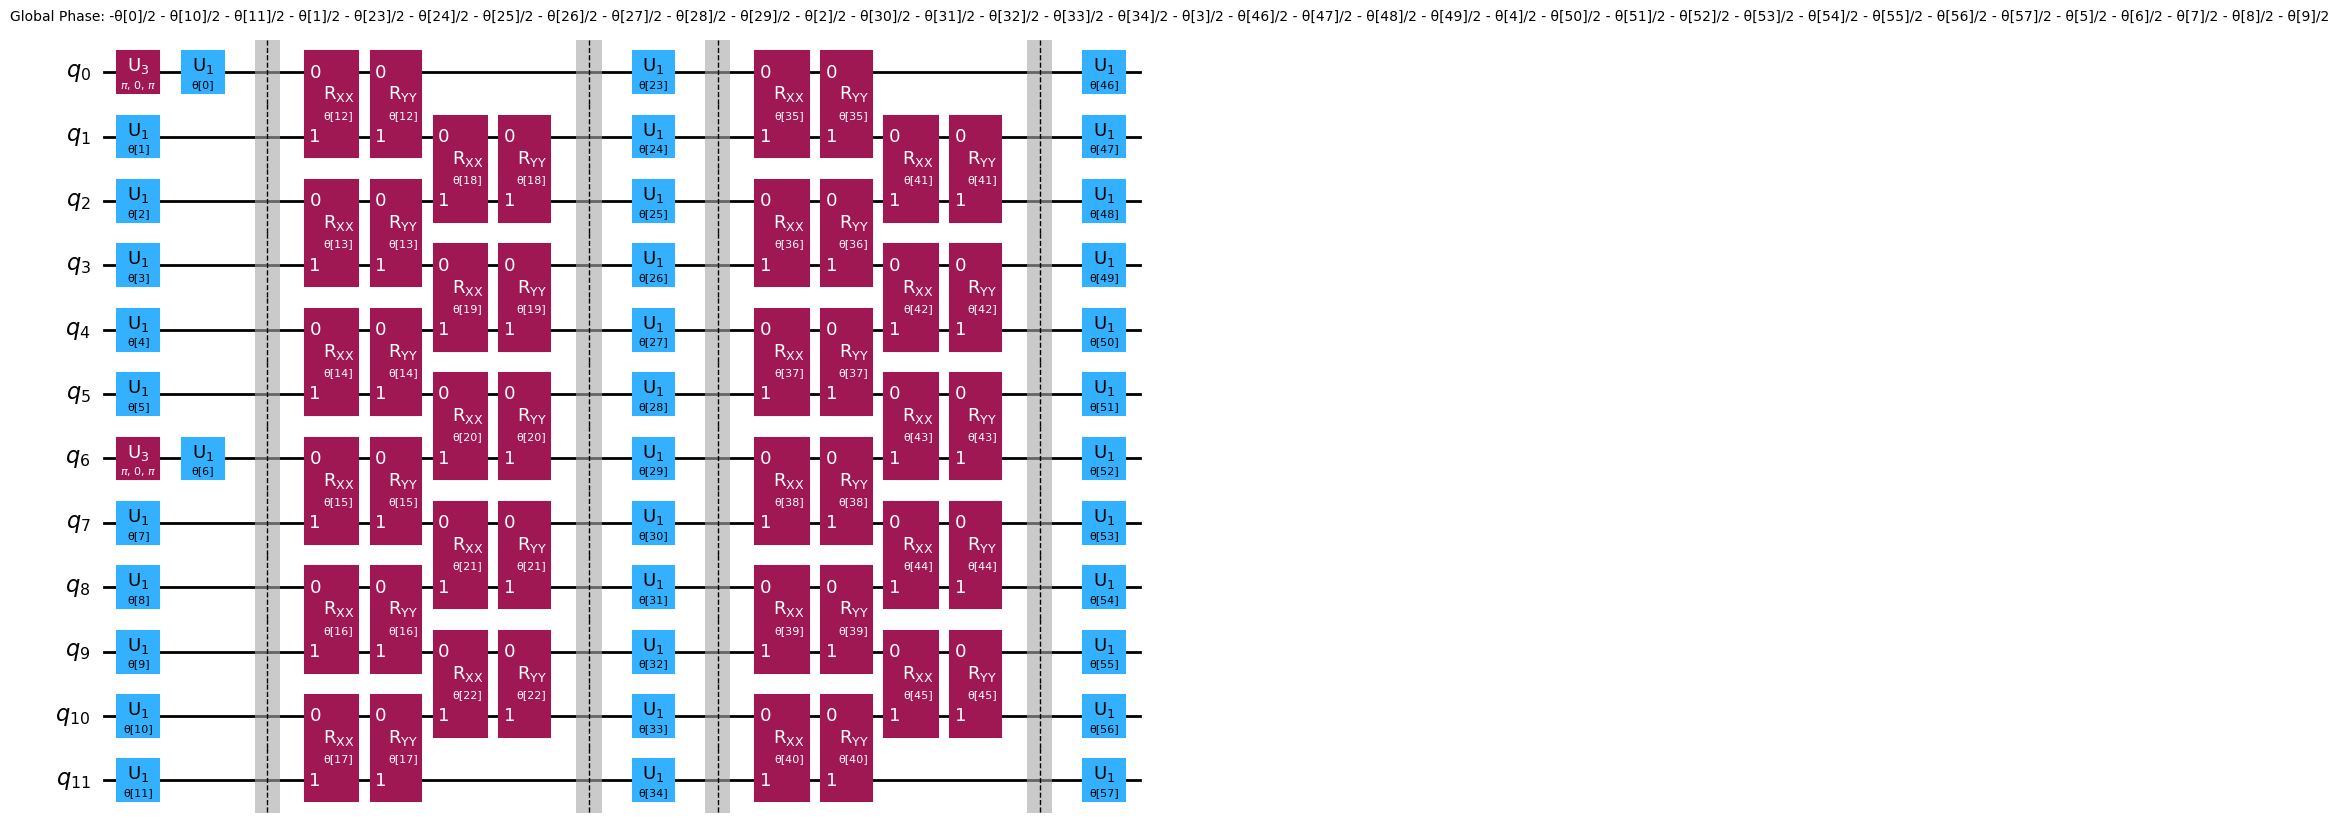

In [6]:

# hamiltonian = JordanWignerMapper().map(fermi_hubb.second_q_op())
hamiltonian = fermi_hubbard_hamiltonian(verticies=verticies, edges=edges)

qc = QuantumCircuit(12)
qc.x(0)
qc.x(6)


# ansatz = evolved_operator_ansatz([edge_op, same_site_op], reps=1, insert_barriers=True)
# ansatz = (n_local(verticies*2, "rz", "cx", "full", reps=2, insert_barriers=True))
# entanglement = [(i+verticies*spin, j+verticies*spin) 
#                 for i,j in edges for spin in [0,1]] + [(i, i+verticies) for i in range(verticies)]
# ansatz = n_local(verticies*2, "rx", "cx", "linear" , reps=10)
ansatz = qc.compose(excitation_preserving(verticies*2, reps=2, 
                                          insert_barriers=True,
                                          skip_final_rotation_layer=False,
                                          entanglement = "pairwise",
                                          mode = "iswap"))
# ansatz = EfficientSU2(hamiltonian.num_qubits)
# ansatz = RealAmplitudes(hamiltonian.num_qubits)

# ansatz = UCC(num_spatial_orbitals=6, 
#              num_particles=(1,1),
#              qubit_mapper=JordanWignerMapper(),
#              excitations=2)

ansatz.draw("mpl")

num_of_parameters = ansatz.num_parameters

print(f"There are {num_of_parameters} parameters.")
ansatz.decompose().draw("mpl", style="iqp")

In [7]:
target = backend.target
pm:PassManager = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)
target.operation_names
# ansatz_isa.decompose().draw("mpl", style="iqp")

dict_keys(['h', 'u3', 'mcr', 'x', 'cu', 'save_matrix_product_state', 'ry', 'id', 'mcrz', 'crx', 'mcrx', 'cy', 'break_loop', 'save_expval_var', 'unitary', 'save_superop', 'ccx', 'mcx', 'save_probabilities', 'rzz', 'save_state', 'cry', 'save_density_matrix', 'pauli', 'mcsx', 'cu2', 'rzx', 'mcphase', 'store', 'sdg', 'set_statevector', 'delay', 'save_clifford', 'superop', 'save_stabilizer', 'save_expval', 'continue_loop', 'y', 'ccz', 'ecr', 'cx', 'tdg', 'z', 'u2', 'measure', 'r', 'initialize', 'sxdg', 'cz', 'save_probabilities_dict', 'mcswap', 'quantum_channel', 'mcu3', 'qerror_loc', 'rxx', 'cu3', 'cu1', 'mcry', 'reset', 'while_loop', 'save_statevector_dict', 'save_unitary', 'save_amplitudes_sq', 'if_else', 'mcz', 'mcp', 'for_loop', 'mcu1', 'rz', 's', 'diagonal', 'u1', 'save_statevector', 'sx', 'u', 'cswap', 'mcy', 'kraus', 'set_unitary', 'mcx_gray', 'mcu2', 'p', 'roerror', 'csx', 'cp', 'save_amplitudes', 'set_density_matrix', 'ryy', 'set_stabilizer', 't', 'crz', 'set_superop', 'mcu', 'mul

In [8]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [9]:
x0 = 2 * np.pi * np.random.random(num_of_parameters)
x0

# x0 = np.array([ 3.81753823,  4.82121225,  4.67535109,  3.0675717 ,  3.46028147,
#         2.2842241 ,  2.28068808,  2.93173167,  4.45084888,  3.59009141,
#         6.22908827,  0.69924701,  4.02079642,  1.27397888,  4.55890384,
#         1.8248962 ,  1.50390195,  4.79395989,  0.98523768,  6.11700762,
#         0.13819355,  7.01209955,  5.33633725,  0.65456489,  1.20210642,
#         0.83180232,  5.82866698,  5.19575042,  3.31176441,  5.50647245,
#         2.76759528,  2.94891426,  3.90298021,  5.33175021,  4.30725485,
#         5.01166516,  1.24604705,  3.44888302,  5.73396634,  5.35505843,
#        -0.28159186,  4.28582381,  5.46612932, -0.11433386,  4.83048706,
#         4.14032701,  2.36388634,  4.38384209,  6.34758701,  7.05600274,
#         5.77834296,  4.9689087 ,  3.62937989,  5.05953697,  3.79919937,
#         1.58854063,  3.4267587 ,  7.68951643])
len(x0)

58

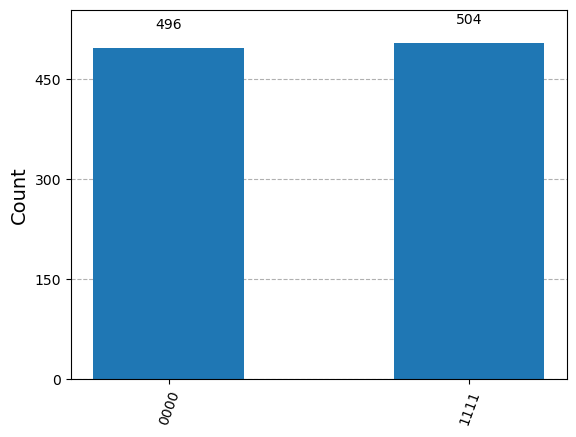

In [10]:
# check noise
num_qubits = 4

circuit = QuantumCircuit(num_qubits)
circuit.h(0)
for j in range(1,num_qubits):
    circuit.cx(0, j)
circuit.measure_all()

transpiled_circuit = transpile(circuit, backend)
sampler = SamplerV2(backend)
job = sampler.run([transpiled_circuit], shots=1000)
pub_result = job.result()[0]
counts = pub_result.data.meas.get_counts()
plot_histogram(counts)

In [ ]:

print(ansatz_isa.count_ops())

OrderedDict({'rz': 36, 'rxx': 22, 'ryy': 22, 'barrier': 4, 'x': 2})


In [12]:


# estimator = Estimator(backend)
# pub = (ansatz_isa, [hamiltonian_isa], x0)
# result = estimator.run(pubs=[pub]).result()
# energy = result[0].data.evs[0]


In [13]:

# from qiskit.quantum_info import Statevector
# [(f"{s:012b}", c) for s, c in enumerate(Statevector(applied_ansatz).data) if abs(c) > 1e-10]


# x_final = cost_history_dict["prev_vector"]

In [14]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 4000

    res = sci.optimize.minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )
print("done")

Iters. done: 1 [Current cost: 0.9960009997500625]
Iters. done: 2 [Current cost: 0.9475131217195703]
Iters. done: 3 [Current cost: 1.014496375906024]
Iters. done: 4 [Current cost: 0.848537865533616]
Iters. done: 5 [Current cost: 0.9442639340164953]
Iters. done: 6 [Current cost: 1.0309922519370163]
Iters. done: 7 [Current cost: 1.0174956260934762]
Iters. done: 8 [Current cost: 0.9462634341414649]
Iters. done: 9 [Current cost: 1.003999000249938]
Iters. done: 10 [Current cost: 1.0349912521869526]
Iters. done: 11 [Current cost: 1.0319920019995004]
Iters. done: 12 [Current cost: 0.9307673081729562]
Iters. done: 13 [Current cost: 1.019495126218445]
Iters. done: 14 [Current cost: 0.1024743814046487]
Iters. done: 15 [Current cost: 0.189952511872032]
Iters. done: 16 [Current cost: 0.18045488627843054]
Iters. done: 17 [Current cost: 0.1537115721069734]
Iters. done: 18 [Current cost: 0.1654586353411655]
Iters. done: 19 [Current cost: 0.27243189202699325]
Iters. done: 20 [Current cost: -0.728567858

In [15]:
min(cost_history_dict["cost_history"])

np.float64(-5.284928767808048)

In [16]:
cost_history_dict["prev_vector"]

array([ 4.03226345,  0.87226504,  2.04618665,  3.85196479,  4.67374763,
        5.69535129,  0.47066731,  5.14483405,  1.01146952,  2.42746918,
        5.99733405,  0.66749743,  1.42783591,  0.3009957 ,  1.03973455,
        5.0248265 ,  1.18030928,  5.62491012,  5.54646988,  1.98648699,
        0.7212019 ,  4.8261874 ,  1.69925787,  5.28851648,  2.76245158,
        0.68613641,  7.09753407,  4.29378598,  4.51841646,  1.77508028,
        4.84187267,  0.27882141,  5.77749462,  1.81424933,  4.0491214 ,
        5.33120255,  1.0581183 ,  4.04900029,  5.74622983,  4.26852973,
        2.98564999,  4.11519473,  3.86591348,  2.82755485,  2.19844173,
        2.34393281, -0.10654844,  6.07276568,  6.00832825,  0.50990796,
        2.36845346,  2.38123682,  5.03785364,  4.25585211,  6.32819916,
        2.07479077,  0.61345851,  5.17425911])

In [17]:
x_tested = np.array([ 3.20328525,  0.50629641,  3.84852649,  2.30117051,  0.98428264,
        5.76495115, -0.21886031,  1.57764426,  5.25463384,  2.3791917 ,
        5.56806521,  4.79357437,  3.1565955 ,  0.52079769,  3.97013192,
        2.17490099,  3.18787535,  0.41613771,  7.81104021,  1.65496404,
        2.16839862,  0.90335784,  3.77739473,  4.31751935,  4.86233941,
        2.81502464,  0.48060772,  5.39964952,  6.38392663,  4.10061354,
        2.99606164,  4.96229985,  4.86200089,  5.13790409,  2.24846144,
        2.23740769,  1.58113707,  1.97656404,  6.13244339,  5.25636437,
        2.52574831,  0.77893843,  2.33841906,  3.95480198,  5.99588762,
        2.31810707,  5.04309813,  3.30837725,  5.01377114,  1.77222328,
        3.20562413,  0.41329646,  1.82267165,  7.30535474,  0.6556094 ,
        2.36627677,  6.765569  ,  3.38266882])